Text Processing - Tokenization, Lemmatization and Stopword removal

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode,unidecode_expect_ascii,unidecode_expect_nonascii
import re

In [2]:
train_data = pd.read_csv(r"C:/Users/Sabrish/Desktop/Data/train.csv",encoding='cp1252')

In [3]:
test_data = pd.read_csv(r"C:/Users/Sabrish/Desktop/Data/test.csv",encoding='cp1252')

Drop NaN values

In [4]:
train_data = train_data[train_data.content.isnull() == False]
train_data = train_data[train_data.title.isnull() == False]
test_data = test_data[test_data.content.isnull() == False]
test_data = test_data[test_data.title.isnull() == False]

In [5]:
train_data.head()

,Unnamed: 0,title,author,date,read_time,shares,content,category
0,6789,The Unintended Consequences of Leaving Healthc...,Ed Dolan,Aug 27,5.0,128.0,With the failure of repeal and replace at the ...,2
1,7886,"Wyatt Lindquist: Frisbee Enthusiast, Entrepreneur",The Edge of Adulthood,Sep 27,3.0,148.0,Illustration: Shannon WrightIllustration: Shan...,1
2,4488,"Peter Viertel - Novelist, Screenwriter, with D...",Steve Newman Writer,Jun 16,4.0,118.0,"Peter Viertel’s 1992 memoir, Dangerous Friends...",0
3,8298,Why I chose customer-funded growth over taking...,Aytekin Tank,Aug 7,6.0,3500.0,It’s the first page in a familiar story. A col...,1
4,8343,How The Best Leaders Get Truly Honest Feedback...,Robert Glazer,Aug 3,4.0,42.0,The purpose of giving feedback to someone is t...,1


In [6]:
train_data.shape

(8601, 8)

In [7]:
test_data.shape

(3692, 8)

In [8]:
stp = stopwords.words('english')

Convert to lowercase

In [9]:
train_data.content = train_data.content.str.lower()
test_data.content = test_data.content.str.lower()

In [10]:
train_data.content.head()

0    with the failure of repeal and replace at the ...
1    illustration: shannon wrightillustration: shan...
2    peter viertel’s 1992 memoir, dangerous friends...
3    it’s the first page in a familiar story. a col...
4    the purpose of giving feedback to someone is t...
Name: content, dtype: object

In [11]:
test_data.content.head()

0    and now, on top of trump’s campaign to lift th...
1    after watching the good place (if you haven’t ...
2    during the days leading up to tuesday, novembe...
3    illustration by zoe van dijkwith age comes wis...
4    beyoncé was one of the first high-profile rule...
Name: content, dtype: object

Perform Inflectional and derivational stemming - using StanfordNLP tokenizer and Lemmatization

In [12]:
from stanfordcorenlp import StanfordCoreNLP
import string
nlp = StanfordCoreNLP('C:\\tools\\stanford-corenlp-full-2018-02-27\\',lang='en')
snb_stm = nltk.SnowballStemmer('english',ignore_stopwords=stp)
lem = nltk.stem.WordNetLemmatizer()

Regex based filters

In [13]:
pattern_skip_decimals = re.compile(r"\s*[\.]{1}")
pattern_skip_digits = re.compile(r"^\d+$")
pattern_single_dec_joins = re.compile(r"\S+(\.){1}([^\.]+)$")
pattern_abbreviations_with_dec = re.compile(r"([a-zA-Z0-9]\W)+")
pattern_abbreviations_general = re.compile(r"([a-zA-Z0-9]+(?=\S)(?=\D)(?=\W))+")

Pre-preocessor function

In [14]:
def procedure(text):
        
        token_split = []
        tokens = []
    
        #Tokenize using StanfordCoreNLP tokenizer, if error default to nltk tokenizer
        try:
            tokens = nlp.word_tokenize(text)
        except:
            print("Resorting to NLTK tokenizer")
            tokens = nltk.word_tokenize(text)
        
        #Exclude stopwords, decimals, pure numbers, and punctutations
        tokens = [token for token in tokens if token not in stp]
        tokens = [token for token in tokens if not pattern_skip_decimals.match(token)]
        tokens = [token for token in tokens if not pattern_skip_digits.match(token)]
        tokens = [token for token in tokens if token not in string.punctuation]

        #Extract potential tokens joined by single dec, punctuations, and stopwords if pulled
        token_split = [token.split('.') for token in tokens if pattern_single_dec_joins.match(token)]
        token_split = [item for tok in token_split for item in tok]
        tokens = [token for token in tokens if not pattern_single_dec_joins.match(token)]
        tokens = tokens + token_split
        tokens = [token for token in tokens if token not in stp]
        tokens = [token for token in tokens if not pattern_skip_decimals.match(token)]
        tokens = [token for token in tokens if not pattern_skip_digits.match(token)]
        tokens = [token for token in tokens if token not in string.punctuation]

        #Extract decimaled and hyphened abbreviations - remove decimals and hypens and join
        token_split = [token for token in tokens if pattern_abbreviations_with_dec.match(token)]
        token_split = [token.replace(".","") for token in token_split]
        token_split = [token.upper() for token in token_split]
        tokens = [token for token in tokens if not pattern_abbreviations_with_dec.match(token)]
        tokens = tokens + token_split
        tokens = [token for token in tokens if token not in stp]
        tokens = [token for token in tokens if not pattern_skip_decimals.match(token)]
        tokens = [token for token in tokens if not pattern_skip_digits.match(token)]
        tokens = [token for token in tokens if token not in string.punctuation]

        #Extract general punct flows
        token_split = [re.split(r"\W",token) for token in tokens if pattern_abbreviations_general.match(token)]
        token_split = [item for tok in token_split for item in tok]
        tokens = [token for token in tokens if not pattern_abbreviations_general.match(token)]
        tokens = tokens + token_split
        tokens = [token for token in tokens if token not in stp]
        tokens = [token for token in tokens if not pattern_skip_decimals.match(token)]
        tokens = [token for token in tokens if not pattern_skip_digits.match(token)]
        tokens = [token for token in tokens if token not in string.punctuation]

        #Lemmatize and extract important tokens
        tokens = [lem.lemmatize(token) for token in tokens if token not in stp]
        tokens = [token for token in tokens if len(token) >= 3]
        tokens = [token for token in tokens if not pattern_skip_decimals.match(token)]
        tokens = [token for token in tokens if not pattern_skip_digits.match(token)]
        tokens = [token for token in tokens if token not in string.punctuation]
            
        return tokens

In [15]:
def pre_processor(text):
    tokenized = procedure(text)
    tokenized_text = " ".join(tokenized)
    return tokenized_text

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

In [17]:
input_text_vector = train_data.content.apply(pre_processor)
input_text_vector_test = test_data.content.apply(pre_processor)

Resorting to NLTK tokenizer
Resorting to NLTK tokenizer
Resorting to NLTK tokenizer
Resorting to NLTK tokenizer
Resorting to NLTK tokenizer
Resorting to NLTK tokenizer


In [18]:
(sum(train_data.category == 0) + sum(train_data.category == 1) + sum(train_data.category == 2) + sum(train_data.category == 3) + sum(train_data.category == 4) + sum(train_data.category == 5))/6 

1433.5

In [19]:
tf_idf = TfidfVectorizer(stop_words=stp,norm='l2',use_idf=True,sublinear_tf=True,min_df=3, max_df=1434)

In [20]:
X = tf_idf.fit_transform(input_text_vector)
X_test = tf_idf.transform(input_text_vector_test)

In [21]:
X.shape

(8601, 42292)

In [22]:
svd = TruncatedSVD(4200)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [23]:
X.shape

(8601, 42292)

In [24]:
X_test.shape

(3692, 42292)

In [25]:
X_lsa = lsa.fit_transform(X)

In [26]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 81%


In [27]:
X_lsa_test = lsa.transform(X_test)

In [28]:
train_data.head()

,Unnamed: 0,title,author,date,read_time,shares,content,category
0,6789,The Unintended Consequences of Leaving Healthc...,Ed Dolan,Aug 27,5.0,128.0,with the failure of repeal and replace at the ...,2
1,7886,"Wyatt Lindquist: Frisbee Enthusiast, Entrepreneur",The Edge of Adulthood,Sep 27,3.0,148.0,illustration: shannon wrightillustration: shan...,1
2,4488,"Peter Viertel - Novelist, Screenwriter, with D...",Steve Newman Writer,Jun 16,4.0,118.0,"peter viertel’s 1992 memoir, dangerous friends...",0
3,8298,Why I chose customer-funded growth over taking...,Aytekin Tank,Aug 7,6.0,3500.0,it’s the first page in a familiar story. a col...,1
4,8343,How The Best Leaders Get Truly Honest Feedback...,Robert Glazer,Aug 3,4.0,42.0,the purpose of giving feedback to someone is t...,1


In [29]:
train_data.drop(["Unnamed: 0"],axis=1,inplace=True)

In [30]:
train_data.shape

(8601, 7)

In [31]:
test_data.head()

,Unnamed: 0,title,author,date,read_time,shares,content,category
0,6902,"Deep State, or State of Deep Troubles?",LA Progressive,Aug 19,3.0,NaN,"and now, on top of trump’s campaign to lift th...",2
1,4787,Maybe life isn’t about getting to the Good Place.,Christine Wei,May 23,3.0,76.0,after watching the good place (if you haven’t ...,0
2,7755,"The Contemporary College Campus: Free Speech, ...",Gaby Goldberg,Jul 14,11.0,NaN,"during the days leading up to tuesday, novembe...",2
3,9055,Is Aging a Disease?,Elysium Health,Sep 21,8.0,365.0,illustration by zoe van dijkwith age comes wis...,3
4,2972,To Be Seen Is to Be Heard: Visibility Is No Lo...,DJBooth,Oct 1,8.0,3.0,beyoncé was one of the first high-profile rule...,0


In [32]:
test_data.drop(["Unnamed: 0"],axis=1,inplace=True)

In [33]:
test_data.shape

(3692, 7)

In [34]:
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

In [35]:
train_data.drop(["index"],axis=1,inplace=True)
train_data

,title,author,date,read_time,shares,content,category
0,The Unintended Consequences of Leaving Healthc...,Ed Dolan,Aug 27,5.0,128.0,with the failure of repeal and replace at the ...,2
1,"Wyatt Lindquist: Frisbee Enthusiast, Entrepreneur",The Edge of Adulthood,Sep 27,3.0,148.0,illustration: shannon wrightillustration: shan...,1
2,"Peter Viertel - Novelist, Screenwriter, with D...",Steve Newman Writer,Jun 16,4.0,118.0,"peter viertel’s 1992 memoir, dangerous friends...",0
3,Why I chose customer-funded growth over taking...,Aytekin Tank,Aug 7,6.0,3500.0,it’s the first page in a familiar story. a col...,1
4,How The Best Leaders Get Truly Honest Feedback...,Robert Glazer,Aug 3,4.0,42.0,the purpose of giving feedback to someone is t...,1
5,Trust or Distrust Drives Social Groups,Steven Gibson,Aug 5,6.0,6.0,trust or distrust drives social groupsracial a...,2
6,Silicon Valley’s Business of Giving,Thomas McMullan,Sep 12,9.0,979.0,credit: tangi bertin via flickr/cc by 2.0credi...,1
7,The £$€ Case for Joining a Startup,Mathias Pastor,Sep 24,5.0,355.0,people point to two main risks when considerin...,1
8,It’s Time to Leave San Francisco,Sunil Rajaraman,Mar 13,7.0,29000.0,that’s it. the kevin roose article in the new ...,5
9,"After 11 Years, NASA’s Asteroid-Hopping Spacec...",Popular Science,Sep 11,7.0,234.0,"by shannon stironerunning low on fuel, nasa’s ...",3


In [36]:
train_data.shape

(8601, 7)

In [37]:
test_data.drop(["index"],axis=1,inplace=True)
test_data

,title,author,date,read_time,shares,content,category
0,"Deep State, or State of Deep Troubles?",LA Progressive,Aug 19,3.0,NaN,"and now, on top of trump’s campaign to lift th...",2
1,Maybe life isn’t about getting to the Good Place.,Christine Wei,May 23,3.0,76.0,after watching the good place (if you haven’t ...,0
2,"The Contemporary College Campus: Free Speech, ...",Gaby Goldberg,Jul 14,11.0,NaN,"during the days leading up to tuesday, novembe...",2
3,Is Aging a Disease?,Elysium Health,Sep 21,8.0,365.0,illustration by zoe van dijkwith age comes wis...,3
4,To Be Seen Is to Be Heard: Visibility Is No Lo...,DJBooth,Oct 1,8.0,3.0,beyoncé was one of the first high-profile rule...,0
5,The Constitution is Showing its Age,Friendly Neighborhood Writer,Oct 1,6.0,77.0,"the world around us changes every day. thus, u...",2
6,Twitter Wants to Reduce the “Health” of its Co...,MIT Technology Review,Mar 10,3.0,102.0,by rachel metztwitter needs a checkup. after y...,5
7,Understanding Incentive Stock Options,Katie Siegel,Sep 20,6.0,376.0,this article is a non-official resource on eva...,1
8,The Fall of Soranet,Inigo Gonzalez,May 2,7.0,27.0,"a story of revenge porn, obscene profits, and ...",0
9,I Saw Myself in Meg Murry Even Before She Look...,Tajja Isen,Mar 13,9.0,231.0,almost two decades before ava duvernay’s adapt...,0


In [38]:
test_data.shape

(3692, 7)

In [39]:
X_lsa = pd.DataFrame(X_lsa)
X_train = pd.concat([X_lsa,train_data.iloc[:,[3,4]]],axis=1)
Y_train = train_data.category

In [40]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4192,4193,4194,4195,4196,4197,4198,4199,read_time,shares
0,0.174240,0.051220,0.101647,0.046994,0.083604,-0.008395,0.024496,-0.062761,0.009280,0.035369,...,0.004886,-0.016340,0.002116,0.004269,-0.005414,0.002557,-0.006442,-0.001114,5.0,128.0
1,0.102112,0.010731,-0.044324,-0.023960,0.058909,0.040822,0.021279,0.045834,0.020890,-0.026545,...,-0.001133,0.004088,-0.001189,0.000582,0.006241,-0.003957,-0.003796,0.000637,3.0,148.0
2,0.103234,-0.064651,-0.024023,-0.002246,-0.019861,0.068916,-0.041246,0.006415,0.036863,-0.001541,...,0.014431,0.003637,0.013911,-0.008388,-0.001744,-0.013700,0.020613,0.004701,4.0,118.0
3,0.196980,0.083815,-0.047854,-0.062690,0.150729,0.019206,0.032744,0.064105,0.007388,-0.050692,...,0.005339,0.012322,-0.000406,-0.004601,0.015737,0.006065,0.001436,0.004226,6.0,3500.0
4,0.190309,0.030344,-0.009718,-0.058891,0.095015,-0.082562,0.021716,0.024731,0.002837,-0.043685,...,0.007456,0.004312,0.009077,0.000851,0.008443,-0.003002,0.001599,0.001243,4.0,42.0


In [41]:
Y_train.head()

0    2
1    1
2    0
3    1
4    1
Name: category, dtype: int64

In [42]:
X_lsa_test = pd.DataFrame(X_lsa_test)
X_test = pd.concat([X_lsa_test,test_data.iloc[:,[3,4]]],axis=1)
Y_test = test_data.category

In [43]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4192,4193,4194,4195,4196,4197,4198,4199,read_time,shares
0,0.223990,-0.017034,0.286097,0.018150,0.023754,0.005431,-0.075979,-0.071337,-0.071117,-0.051419,...,0.010168,-0.008166,-0.010290,-0.003452,0.009067,-0.005245,0.006265,-0.024527,3.0,NaN
1,0.181891,-0.020777,-0.041243,0.005991,0.067718,-0.076951,0.001245,-0.012827,-0.052418,0.020507,...,0.001561,0.003573,-0.015702,0.014888,-0.006300,-0.005844,-0.007472,0.003863,3.0,76.0
2,0.363360,-0.099502,0.265022,0.029087,0.000307,-0.147771,-0.052348,-0.001062,0.023201,0.046379,...,-0.015353,0.005373,0.001435,0.004719,-0.007793,0.007537,-0.002373,-0.000276,11.0,NaN
3,0.283059,0.059739,0.035677,0.245118,0.032693,-0.072159,0.103750,-0.145838,0.177689,-0.040960,...,0.005487,-0.001778,0.002998,-0.000677,-0.019515,-0.015099,0.001307,0.012058,8.0,365.0
4,0.337823,-0.023599,-0.071299,-0.052915,-0.106497,0.066821,-0.180684,0.134311,0.062370,-0.019854,...,0.012002,-0.006181,-0.002989,0.026830,0.007803,0.016653,-0.007914,-0.007569,8.0,3.0


In [44]:
Y_test.head()

0    2
1    0
2    2
3    3
4    0
Name: category, dtype: int64

Carry on from here...90-10 for train-validation on X_train, Y_train and build MLP

In [121]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split

X_train = pd.read_csv("C:/Users/Sabrish/Desktop/Data/X_train.csv",encoding='cp1252')
Y_train = pd.read_csv("C:/Users/Sabrish/Desktop/Data/Y_train.csv",encoding='cp1252')

X_test = pd.read_csv("C:/Users/Sabrish/Desktop/Data/X_test.csv",encoding="cp1252")
Y_test = pd.read_csv("C:/Users/Sabrish/Desktop/Data/Y_test.csv",encoding="cp1252")

In [17]:
data_merged = pd.concat([X_train,Y_train],axis=1)

In [18]:
data_merged_test = pd.concat([X_test,Y_test],axis=1)

In [19]:
data_merged.dropna(inplace=True)

In [20]:
data_merged_test.dropna(inplace=True)

In [51]:
data_merged.shape

(8387, 4203)

In [52]:
data_merged_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4193,4194,4195,4196,4197,4198,4199,read_time,shares,category
1,0.181891,-0.020777,-0.041243,0.005991,0.067718,-0.076951,0.001245,-0.012827,-0.052418,0.020507,...,0.003573,-0.015702,0.014888,-0.006300,-0.005844,-0.007472,0.003863,3.0,76.0,0
3,0.283059,0.059739,0.035677,0.245118,0.032693,-0.072159,0.103750,-0.145838,0.177689,-0.040960,...,-0.001778,0.002998,-0.000677,-0.019515,-0.015099,0.001307,0.012058,8.0,365.0,3
4,0.337823,-0.023599,-0.071299,-0.052915,-0.106497,0.066821,-0.180684,0.134311,0.062370,-0.019854,...,-0.006181,-0.002989,0.026830,0.007803,0.016653,-0.007914,-0.007569,8.0,3.0,0
5,0.293141,-0.051269,0.272504,0.029586,0.005622,-0.048871,0.093122,0.046589,-0.103592,-0.058013,...,0.005042,0.005395,-0.005186,-0.001275,0.001934,-0.020059,0.004999,6.0,77.0,2
6,0.216865,0.084263,0.041133,0.011289,-0.046561,-0.112230,-0.032621,-0.018923,0.048389,-0.033280,...,-0.010687,-0.008289,0.004225,0.001723,0.013275,-0.000705,0.005270,3.0,102.0,5


In [53]:
data_merged_test.shape

(3599, 4203)

In [54]:
X_train = data_merged.iloc[:,:4202]
Y_train = data_merged.category

In [55]:
X_train.shape

(8387, 4202)

In [56]:
Y_train.shape

(8387,)

In [57]:
X_test = data_merged_test.iloc[:,:4202]
Y_test = data_merged_test.category

In [58]:
X_test.shape

(3599, 4202)

In [59]:
Y_test.shape

(3599,)

In [60]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4192,4193,4194,4195,4196,4197,4198,4199,read_time,shares
0,0.174240,0.051220,0.101647,0.046994,0.083604,-0.008395,0.024496,-0.062761,0.009280,0.035369,...,0.004886,-0.016340,0.002116,0.004269,-0.005414,0.002557,-0.006442,-0.001114,5.0,128.0
1,0.102112,0.010731,-0.044324,-0.023960,0.058909,0.040822,0.021279,0.045834,0.020890,-0.026545,...,-0.001133,0.004088,-0.001189,0.000582,0.006241,-0.003957,-0.003796,0.000637,3.0,148.0
2,0.103234,-0.064651,-0.024023,-0.002246,-0.019861,0.068916,-0.041246,0.006415,0.036863,-0.001541,...,0.014431,0.003637,0.013911,-0.008388,-0.001744,-0.013700,0.020613,0.004701,4.0,118.0
3,0.196980,0.083815,-0.047854,-0.062690,0.150729,0.019206,0.032744,0.064105,0.007388,-0.050692,...,0.005339,0.012322,-0.000406,-0.004601,0.015737,0.006065,0.001436,0.004226,6.0,3500.0
4,0.190309,0.030344,-0.009718,-0.058891,0.095015,-0.082562,0.021716,0.024731,0.002837,-0.043685,...,0.007456,0.004312,0.009077,0.000851,0.008443,-0.003002,0.001599,0.001243,4.0,42.0


<b>Note: From here, choose to proceed to part 2 - SVM or continue below to part 1 - Neural Network</b>

In [122]:
X_train,X_validate,Y_train,Y_validate = train_test_split(X_train,Y_train,test_size=0.15,random_state=0)

<b>1. Neural Network with SMOTE</b>

In [123]:
import keras
import tensorflow as tf

D:\ANACONDA\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [124]:
tf.Session(config=tf.ConfigProto(log_device_placement=True))

SMOTE imbalance

In [125]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

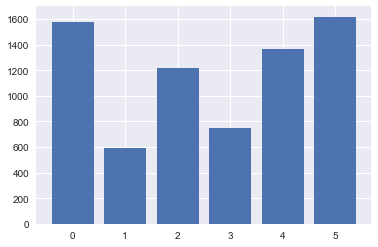

In [127]:
plt.bar(height = list(Y_train.Target.value_counts()),x=list(Y_train.Target.value_counts().index))
plt.show()

In [90]:
smoter = SMOTE(random_state=46)
X_train_resampled, Y_train_resampled = smoter.fit_sample(X_train,Y_train)
X_train_resampled = pd.DataFrame(X_train_resampled,columns=X_train.columns)
Y_train_resampled = pd.DataFrame(Y_train_resampled,columns=["Target"])

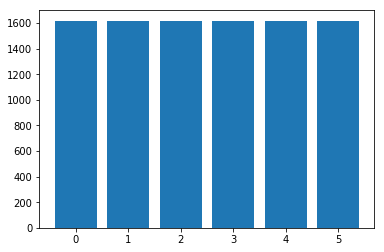

In [91]:
plt.bar(height = list(Y_train_resampled.Target.value_counts()),x=list(Y_train_resampled.Target.value_counts().index))
plt.show()

One-hot target and normalize unnormalized columns in X

In [92]:
Y_train_cat = keras.utils.to_categorical(Y_train_resampled)
Y_validate_cat = keras.utils.to_categorical(Y_validate)

In [95]:
from sklearn.preprocessing import MinMaxScaler

In [98]:
min_max = MinMaxScaler(copy=False)
X_train_resampled.iloc[:,[4200,4201]] = min_max.fit_transform(X_train_resampled.iloc[:,[4200,4201]])

In [100]:
X_validate.iloc[:,[4200,4201]] = min_max.fit_transform(X_validate.iloc[:,[4200,4201]])

Build Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras import metrics

model = Sequential()
model.add(Dense(4000, activation='relu', input_dim=4202))
model.add(Dropout(0.5))
model.add(Dense(3500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1200, activation = 'relu'))
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.75))
model.add(Dense(75, activation = 'relu'))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=[metrics.mae, metrics.categorical_accuracy])

model.fit(X_train_resampled, Y_train_cat,
          epochs=120,
          batch_size=50)
score = model.evaluate(X_validate, Y_validate_cat, batch_size=50)

Test Model on X_test and Y_test...need to do some preprocessing

In [103]:
X_test.iloc[:,[4200,4201]] = min_max.transform(X_test.iloc[:,[4200,4201]])

In [132]:
predictions = model.predict_classes(X_test)

In [133]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sn

In [134]:
print(confusion_matrix(y_pred=predictions,y_true=Y_test))

[[514  22 118  15 105  50]
 [ 11 221   5   2  47  44]
 [ 61   9 481   5  14  28]
 [ 28   3  25 262  13  49]
 [ 78  35  28   9 534   8]
 [ 33  58  57  42  32 553]]


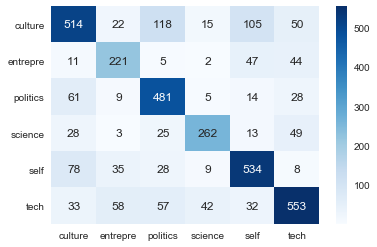

In [135]:
df_cm = pd.DataFrame(confusion_matrix(y_pred=predictions,y_true=Y_test), index = [i for i in ["culture","entrepre","politics","science","self","tech"]],
                  columns = [i for i in ["culture","entrepre","politics","science","self","tech"]])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)
sn.heatmap(df_cm, annot=True,cmap="Blues",fmt='g')
plt.show()

In [136]:
print(accuracy_score(y_pred=predictions,y_true=Y_test))

0.7126979716587941


In [137]:
print(classification_report(y_pred=predictions,y_true=Y_test))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66       824
           1       0.64      0.67      0.65       330
           2       0.67      0.80      0.73       598
           3       0.78      0.69      0.73       380
           4       0.72      0.77      0.74       692
           5       0.76      0.71      0.73       775

   micro avg       0.71      0.71      0.71      3599
   macro avg       0.71      0.71      0.71      3599
weighted avg       0.72      0.71      0.71      3599



<b>2. SVM without SMOTE</b>

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

In [62]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4192,4193,4194,4195,4196,4197,4198,4199,read_time,shares
0,0.174240,0.051220,0.101647,0.046994,0.083604,-0.008395,0.024496,-0.062761,0.009280,0.035369,...,0.004886,-0.016340,0.002116,0.004269,-0.005414,0.002557,-0.006442,-0.001114,5.0,128.0
1,0.102112,0.010731,-0.044324,-0.023960,0.058909,0.040822,0.021279,0.045834,0.020890,-0.026545,...,-0.001133,0.004088,-0.001189,0.000582,0.006241,-0.003957,-0.003796,0.000637,3.0,148.0
2,0.103234,-0.064651,-0.024023,-0.002246,-0.019861,0.068916,-0.041246,0.006415,0.036863,-0.001541,...,0.014431,0.003637,0.013911,-0.008388,-0.001744,-0.013700,0.020613,0.004701,4.0,118.0
3,0.196980,0.083815,-0.047854,-0.062690,0.150729,0.019206,0.032744,0.064105,0.007388,-0.050692,...,0.005339,0.012322,-0.000406,-0.004601,0.015737,0.006065,0.001436,0.004226,6.0,3500.0
4,0.190309,0.030344,-0.009718,-0.058891,0.095015,-0.082562,0.021716,0.024731,0.002837,-0.043685,...,0.007456,0.004312,0.009077,0.000851,0.008443,-0.003002,0.001599,0.001243,4.0,42.0


In [63]:
min_max = MinMaxScaler(copy=False)
X_train.iloc[:,[4200,4201]] = min_max.fit_transform(X_train.iloc[:,[4200,4201]])

In [64]:
X_test.iloc[:,[4200,4201]] = min_max.transform(X_test.iloc[:,[4200,4201]])

In [65]:
X_train.to_csv("X_train_svc.csv")
Y_train.to_csv("Y_train_svc.csv")
X_test.to_csv("X_test_svc.csv")
Y_test.to_csv("Y_test_svc.csv")

In [2]:
import pandas as pd

In [3]:
X_train = pd.read_csv("X_train_svc.csv")

In [8]:
X_train.drop(['Unnamed: 0'],axis=1,inplace=True)

In [9]:
Y_train = pd.read_csv("Y_train_svc.csv")

In [12]:
X_test = pd.read_csv("X_test_svc.csv")
X_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [13]:
Y_test = pd.read_csv("Y_test_svc.csv")

We found out after grid search that LinearSVC performs better than rbf kernel 

In [113]:
clf = LinearSVC(C=0.08)

In [114]:
clf.fit(X=X_train,y=Y_train.Target)

LinearSVC(C=0.08, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [115]:
predictions = clf.predict(X=X_test)

In [116]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn

In [117]:
confusion_matrix(y_pred=predictions,y_true=Y_test)

array([[582,   6,  93,  17,  79,  47],
       [ 16, 212,   2,   3,  40,  57],
       [ 43,   1, 507,   5,  13,  29],
       [ 25,   0,  10, 306,   6,  33],
       [ 75,  13,   6,   5, 583,  10],
       [ 29,  23,  28,  31,  15, 649]], dtype=int64)

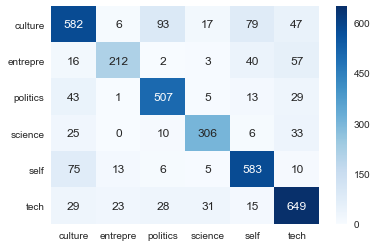

In [118]:
df_cm = pd.DataFrame(confusion_matrix(y_pred=predictions,y_true=Y_test), index = [i for i in ["culture","entrepre","politics","science","self","tech"]],
                  columns = [i for i in ["culture","entrepre","politics","science","self","tech"]])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)
sn.heatmap(df_cm, annot=True,cmap="Blues",fmt='g')
plt.show()

In [119]:
print(classification_report(y_pred=predictions,y_true=Y_test))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       824
           1       0.83      0.64      0.72       330
           2       0.78      0.85      0.82       598
           3       0.83      0.81      0.82       380
           4       0.79      0.84      0.82       692
           5       0.79      0.84      0.81       775

   micro avg       0.79      0.79      0.79      3599
   macro avg       0.80      0.78      0.79      3599
weighted avg       0.79      0.79      0.79      3599

